# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os
import random
import pathlib

import pandas as pd
import torch
from Bio.PDB.Polypeptide import index_to_one
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset

from cavity_model import (
    CavityModel,
    ResidueEnvironment,
    ResidueEnvironmentsDataset,
)
import helpers

from visualization import scatter_pred_vs_true, plot_validation_performance

%load_ext nb_black

<IPython.core.display.Javascript object>

# Cavity Model

Download and process Cavity Model data

In [2]:
# # Hack to find the conda activate path since bash scripts
# # don't necessarily work with the conda activate command
# conda_path = !which conda
# conda_path = list(conda_path)[0]
# conda_activate_path = pathlib.Path(conda_path).parent.parent / "bin" / "activate"
# if not conda_activate_path.is_file():
#     raise FileNotFoundError(
#         "Could not find your conda activate path needed for running bash scripts."
#     )

<IPython.core.display.Javascript object>

In [3]:
# # Run shell script that takes a .txt file with PDBIDs as input.
# !./get_and_parse_pdbs_for_cavity_model.sh $conda_activate_path data/pdbids_2336.txt

<IPython.core.display.Javascript object>

Global variables

In [4]:
# Main parameters
WARM_START = "cavity_models/model_epoch_00.pt"
DEVICE = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 100
SHUFFLE_PDBS = True
LEARNING_RATE = 3e-4
EPOCHS = 2
PATIENCE_CUTOFF = 0
EPS = 1e-9

# Parameters specific to downstream model
BATCH_SIZE_DDG = 40
SHUFFLE_DDG = True
LEARNING_RATE_DDG = 1e-3
EPOCHS_DDG = 200

<IPython.core.display.Javascript object>

Load Parsed PDBs and perform train/val split

In [5]:
if WARM_START is None:
    parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
    if SHUFFLE_PDBS:
        random.shuffle(parsed_pdb_filenames)
    (
        dataloader_train,
        dataset_train,
        dataloader_val,
        dataset_val,
    ) = helpers.train_val_split(
        parsed_pdb_filenames, TRAIN_VAL_SPLIT, DEVICE, BATCH_SIZE
    )
else:
    print(f"Warm start: {WARM_START}")

Warm start: cavity_models/model_epoch_00.pt


<IPython.core.display.Javascript object>

Train the cavity model

In [6]:
if WARM_START is None:
    # Define model
    cavity_model_net = CavityModel(DEVICE).to(DEVICE)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

    # Create directory for model files
    models_dirpath = "cavity_models/"
    if not os.path.exists(models_dirpath):
        os.mkdir(models_dirpath)

    # Train loop
    best_model_path = helpers.train_loop(
        dataloader_train,
        dataloader_val,
        cavity_model_net,
        loss_function,
        optimizer,
        EPOCHS,
        PATIENCE_CUTOFF,
    )
else:
    print(f"Warm start: {WARM_START}")

Warm start: cavity_models/model_epoch_00.pt


<IPython.core.display.Javascript object>

# ddG Prediction

Parse PDBs for DMS, Guerois and Protein G data sets

In [7]:
# # Parse PDBs for which we have ddG data
# !./get_and_parse_pdbs_for_dowstream_task.sh $conda_activate_path

<IPython.core.display.Javascript object>

Make dict for residue environments for easy look up

In [8]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

Load ddG data to dataframe

In [9]:
ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}

<IPython.core.display.Javascript object>

Populate dataframes with wt ResidueEnvironment objects and wt and mt restype indices

In [10]:
helpers.populate_dfs_with_resenvs(ddg_data_dict, resenv_datasets_look_up)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois
dropped    0 /  342 data points from dataset symmetric_direct
dropped    0 /  342 data points from dataset symmetric_inverse


<IPython.core.display.Javascript object>

Populate dataframes with predicted NLLs and isolated WT and MT predicted NLLs as well as NLFs

In [11]:
# Load best performing cavity model from previos training
if WARM_START:
    best_model_path = WARM_START

cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
cavity_model_infer_net.load_state_dict(torch.load(best_model_path))
cavity_model_infer_net.eval()

helpers.populate_dfs_with_nlls_and_nlfs(
    ddg_data_dict, cavity_model_infer_net, DEVICE, BATCH_SIZE, EPS
)

<IPython.core.display.Javascript object>

## Results without downstream model

### Plot with PDB statistics

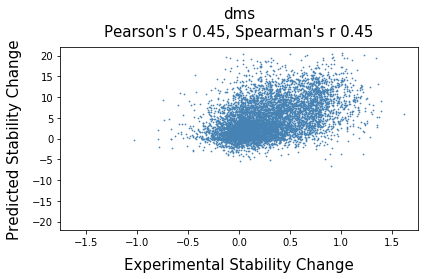

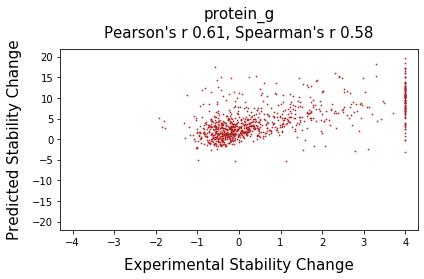

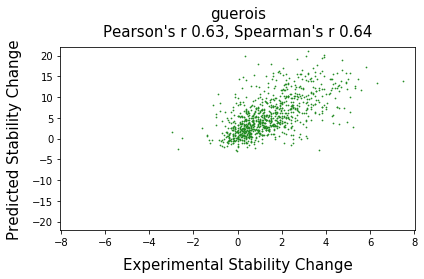

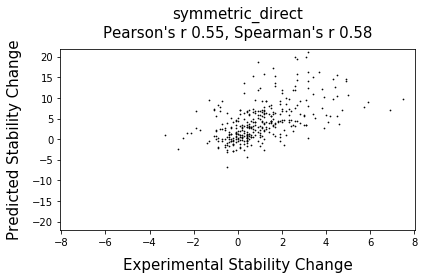

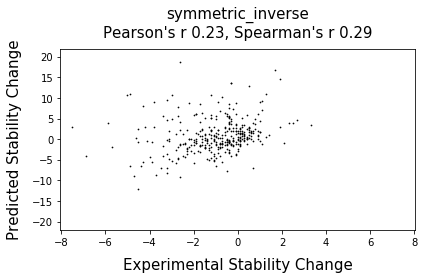

<IPython.core.display.Javascript object>

In [12]:
colors = ["steelblue", "firebrick", "forestgreen", "black", "black"]
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_no_ds"],
        color=color,
        title=data_key,
    )

### Plot with IDP statistics

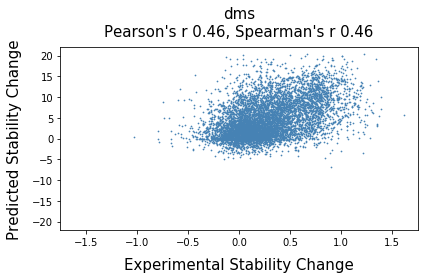

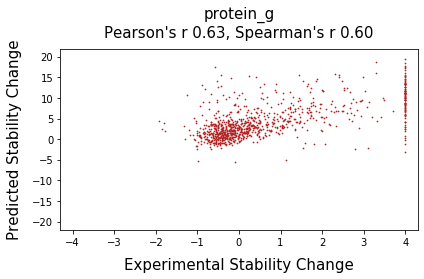

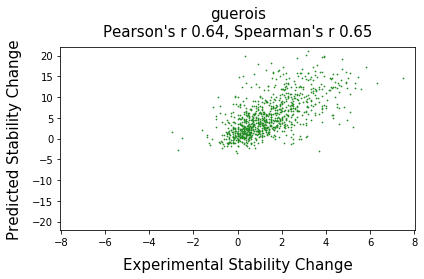

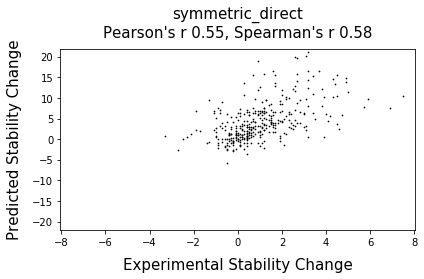

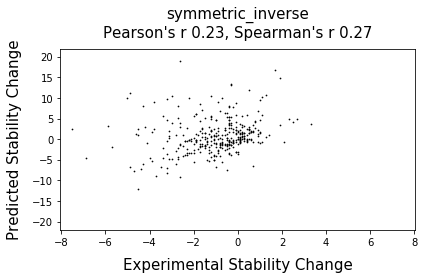

<IPython.core.display.Javascript object>

In [13]:
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_idp_no_ds"],
        color=color,
        title=data_key,
    )

Merge direct and inverse dfs

In [14]:
# Rename columns so they specify if it is the direct or inverse direction
symmetric_direct_df = ddg_data_dict["symmetric_direct"]
symmetric_direct_df.columns = [
    name + "_dir" if "_dir" not in name else name
    for name in symmetric_direct_df.columns
]
symmetric_inverse_df = ddg_data_dict["symmetric_inverse"]
symmetric_inverse_df.columns = [
    name + "_inv" if "_inv" not in name else name
    for name in symmetric_inverse_df.columns
]

# Inner merge both dataframes
ddg_data_dict["symmetric_both"] = pd.merge(
    symmetric_direct_df,
    symmetric_inverse_df,
    how="inner",
    left_on="merge_column_dir",
    right_on="merge_column_inv",
)

<IPython.core.display.Javascript object>

Make prediction based on both structures

In [15]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_dir"] - row["ddg_pred_no_ds_inv"]), axis=1
)
symmetric_both_df["ddg_pred_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_inv"] - row["ddg_pred_no_ds_dir"]), axis=1
)

<IPython.core.display.Javascript object>

In [16]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_idp_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_idp_no_ds_dir"] - row["ddg_pred_idp_no_ds_inv"]),
    axis=1,
)
symmetric_both_df["ddg_pred_idp_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_idp_no_ds_inv"] - row["ddg_pred_idp_no_ds_dir"]),
    axis=1,
)

<IPython.core.display.Javascript object>

### Plot prediction using both structures

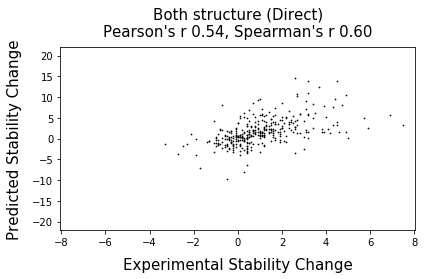

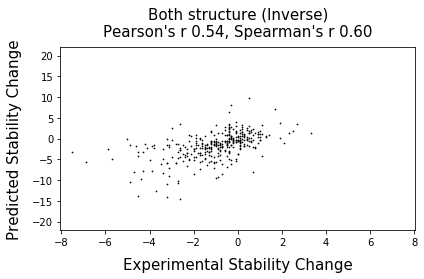

<IPython.core.display.Javascript object>

In [17]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

### Plot prediction using both structures (IDP statistics)

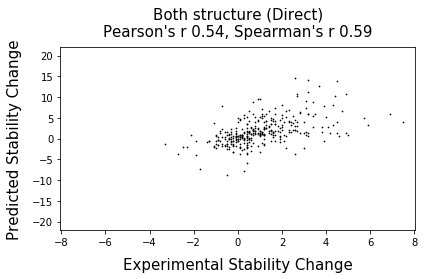

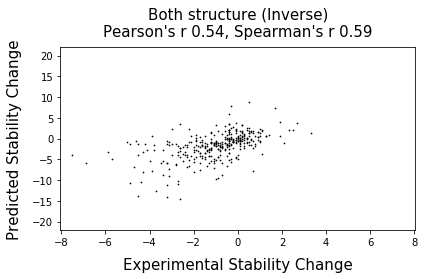

<IPython.core.display.Javascript object>

In [18]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_idp_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_idp_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

### Phaistos statistics

In [20]:
# Add flanking sequence fragments for protein g
raw_pdbs = glob.glob("data/data_protein_g/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    helpers.add_flanking_seq_fragments(
        ddg_data_dict,
        "protein_g",
        raw_pdb,
    )

# Add flanking sequence fragments for guerois
raw_pdbs = glob.glob("data/data_guerois/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    helpers.add_flanking_seq_fragments(
        ddg_data_dict,
        "guerois",
        raw_pdb,
    )

# Add flanking sequence fragments for dms
raw_pdbs = glob.glob("data/data_dms/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    helpers.add_flanking_seq_fragments(
        ddg_data_dict,
        "dms",
        raw_pdb,
    )

/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4562.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4563.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4564.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4565.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontin

/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4264.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4334.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4385.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4551.
  PDBConstructionWarning)


<IPython.core.display.Javascript object>

In [21]:
# Output CSVs (So Wouter can simulate them)
ddg_data_dict["protein_g"][
    ["pdbid", "variant", "left_flank", "right_flank", "wt_restype", "mt_restype"]
].to_csv("data/data_protein_g/sequence_flanks_protein_g.csv")
ddg_data_dict["dms"][
    ["pdbid", "variant", "left_flank", "right_flank", "wt_restype", "mt_restype"]
].to_csv("data/data_dms/sequence_flanks_dms.csv")
ddg_data_dict["guerois"][
    ["pdbid", "variant", "left_flank", "right_flank", "wt_restype", "mt_restype"]
].to_csv("data/data_guerois/sequence_flanks_guerois.csv")

<IPython.core.display.Javascript object>

#### Protein G (phaistos statistics)

In [22]:
# # DROP SOME ROWS FOR QUICKER TESTING
# ddg_data_dict["protein_g"] = ddg_data_dict["protein_g"].iloc[0:10]

<IPython.core.display.Javascript object>

0 1PGA
1 1PGA
2 1PGA
3 1PGA
4 1PGA
5 1PGA
6 1PGA
7 1PGA
8 1PGA
9 1PGA
10 1PGA
11 1PGA
12 1PGA
13 1PGA
14 1PGA
15 1PGA
16 1PGA
17 1PGA
18 1PGA
19 1PGA
20 1PGA
21 1PGA
22 1PGA
23 1PGA
24 1PGA
25 1PGA
26 1PGA
27 1PGA
28 1PGA
29 1PGA
30 1PGA
31 1PGA
32 1PGA
33 1PGA
34 1PGA
35 1PGA
36 1PGA
37 1PGA
38 1PGA
39 1PGA
40 1PGA
41 1PGA
42 1PGA
43 1PGA
44 1PGA
45 1PGA
46 1PGA
47 1PGA
48 1PGA
49 1PGA
50 1PGA
51 1PGA
52 1PGA
53 1PGA
54 1PGA
55 1PGA
56 1PGA
57 1PGA
58 1PGA
59 1PGA
60 1PGA
61 1PGA
62 1PGA
63 1PGA
64 1PGA
65 1PGA
66 1PGA
67 1PGA
68 1PGA
69 1PGA
70 1PGA
71 1PGA
72 1PGA
73 1PGA
74 1PGA
75 1PGA
76 1PGA
77 1PGA
78 1PGA
79 1PGA
80 1PGA
81 1PGA
82 1PGA
83 1PGA
84 1PGA
85 1PGA
86 1PGA
87 1PGA
88 1PGA
89 1PGA
90 1PGA
91 1PGA
92 1PGA
93 1PGA
94 1PGA
95 1PGA
96 1PGA
97 1PGA
98 1PGA
99 1PGA
100 1PGA
101 1PGA
102 1PGA
103 1PGA
104 1PGA
105 1PGA
106 1PGA
107 1PGA
108 1PGA
109 1PGA
110 1PGA
111 1PGA
112 1PGA
113 1PGA
114 1PGA
115 1PGA
116 1PGA
117 1PGA
118 1PGA
119 1PGA
120 1PGA
121 1PGA
122 1PGA
123

22 1PGA
23 1PGA
24 1PGA
25 1PGA
26 1PGA
27 1PGA
28 1PGA
29 1PGA
30 1PGA
31 1PGA
32 1PGA
33 1PGA
34 1PGA
35 1PGA
36 1PGA
37 1PGA
38 1PGA
39 1PGA
40 1PGA
41 1PGA
42 1PGA
43 1PGA
44 1PGA
45 1PGA
46 1PGA
47 1PGA
48 1PGA
49 1PGA
50 1PGA
51 1PGA
52 1PGA
53 1PGA
54 1PGA
55 1PGA
56 1PGA
57 1PGA
58 1PGA
59 1PGA
60 1PGA
61 1PGA
62 1PGA
63 1PGA
64 1PGA
65 1PGA
66 1PGA
67 1PGA
68 1PGA
69 1PGA
70 1PGA
71 1PGA
72 1PGA
73 1PGA
74 1PGA
75 1PGA
76 1PGA
77 1PGA
78 1PGA
79 1PGA
80 1PGA
81 1PGA
82 1PGA
83 1PGA
84 1PGA
85 1PGA
86 1PGA
87 1PGA
88 1PGA
89 1PGA
90 1PGA
91 1PGA
92 1PGA
93 1PGA
94 1PGA
95 1PGA
96 1PGA
97 1PGA
98 1PGA
99 1PGA
100 1PGA
101 1PGA
102 1PGA
103 1PGA
104 1PGA
105 1PGA
106 1PGA
107 1PGA
108 1PGA
109 1PGA
110 1PGA
111 1PGA
112 1PGA
113 1PGA
114 1PGA
115 1PGA
116 1PGA
117 1PGA
118 1PGA
119 1PGA
120 1PGA
121 1PGA
122 1PGA
123 1PGA
124 1PGA
125 1PGA
126 1PGA
127 1PGA
128 1PGA
129 1PGA
130 1PGA
131 1PGA
132 1PGA
133 1PGA
134 1PGA
135 1PGA
136 1PGA
137 1PGA
138 1PGA
139 1PGA
140 1PGA
141 1PG

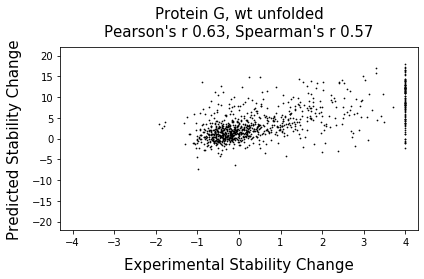

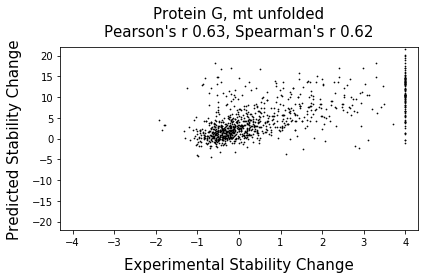

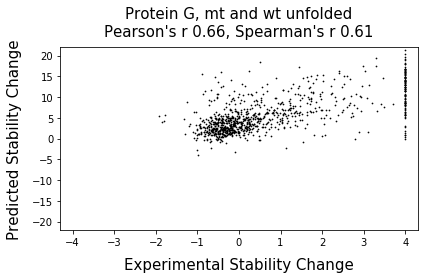

<IPython.core.display.Javascript object>

In [23]:
data_set = "protein_g"
data_set_title = "Protein G"

helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=True
)
helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=False
)
helpers.add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, wt unfolded",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt unfolded",
)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt and wt unfolded",
)

#### Guerois (Phaistos statistics)

In [24]:
# # DROP SOME ROWS FOR QUICKER TESTING
# ddg_data_dict["guerois"] = ddg_data_dict["guerois"].iloc[0:10]

<IPython.core.display.Javascript object>

0 171L
1 1A2P
2 1A2P
3 1A2P
4 1A2P
5 1A2P
6 1A2P
7 1A2P
8 1A2P
9 1A2P
10 1A2P
11 1A2P
12 1A2P
13 1A2P
14 1A2P
15 1A2P
16 1A2P
17 1A2P
18 1A2P
19 1A2P
20 1A2P
21 1A2P
22 1A2P
23 1A2P
24 1A2P
25 1A2P
26 1A2P
27 1A2P
28 1A2P
29 1A2P
30 1A2P
31 1A2P
32 1A2P
33 1A2P
34 1A2P
35 1A2P
36 1A2P
37 1A2P
38 1A2P
39 1A2P
40 1A2P
41 1A2P
42 1A2P
43 1A2P
44 1A2P
45 1A2P
46 1A2P
47 1A2P
48 1A2P
49 1A2P
50 1A2P
51 1A2P
52 1A2P
53 1A2P
54 1A2P
55 1A2P
56 1A2P
57 1A2P
58 1A2P
59 1A2P
60 1A2P
61 1A2P
62 1A2P
63 1A2P
64 1ANF
65 1ANF
66 1ANF
67 1ANF
68 1BF4
69 1BF4
70 1BF4
71 1BF4
72 1BF4
73 1BF4
74 1BF4
75 1BF4
76 1BF4
77 1BF4
78 1BF4
79 1BF4
80 1BF4
81 1BF4
82 1BF4
83 1BF4
84 1BF4
85 1BF4
86 1BPI
87 1BPI
88 1BPI
89 1BPI
90 1BPI
91 1BPI
92 1BPI
93 1BPI
94 1BPI
95 1BPI
96 1BPI
97 1BPI
98 1BPI
99 1BPI
100 1BPI
101 1BPI
102 1BPI
103 1BPI
104 1BPI
105 1BPI
106 1BPI
107 1BPI
108 1BPI
109 1BPI
110 1BPI
111 1BPI
112 1BPI
113 1BPI
114 1BPI
115 1BPI
116 1BPI
117 1BPI
118 1BPI
119 1BPI
120 1BPI
121 1BVC
122 1BVC
123

17 1A2P
18 1A2P
19 1A2P
20 1A2P
21 1A2P
22 1A2P
23 1A2P
24 1A2P
25 1A2P
26 1A2P
27 1A2P
28 1A2P
29 1A2P
30 1A2P
31 1A2P
32 1A2P
33 1A2P
34 1A2P
35 1A2P
36 1A2P
37 1A2P
38 1A2P
39 1A2P
40 1A2P
41 1A2P
42 1A2P
43 1A2P
44 1A2P
45 1A2P
46 1A2P
47 1A2P
48 1A2P
49 1A2P
50 1A2P
51 1A2P
52 1A2P
53 1A2P
54 1A2P
55 1A2P
56 1A2P
57 1A2P
58 1A2P
59 1A2P
60 1A2P
61 1A2P
62 1A2P
63 1A2P
64 1ANF
65 1ANF
66 1ANF
67 1ANF
68 1BF4
69 1BF4
70 1BF4
71 1BF4
72 1BF4
73 1BF4
74 1BF4
75 1BF4
76 1BF4
77 1BF4
78 1BF4
79 1BF4
80 1BF4
81 1BF4
82 1BF4
83 1BF4
84 1BF4
85 1BF4
86 1BPI
87 1BPI
88 1BPI
89 1BPI
90 1BPI
91 1BPI
92 1BPI
93 1BPI
94 1BPI
95 1BPI
96 1BPI
97 1BPI
98 1BPI
99 1BPI
100 1BPI
101 1BPI
102 1BPI
103 1BPI
104 1BPI
105 1BPI
106 1BPI
107 1BPI
108 1BPI
109 1BPI
110 1BPI
111 1BPI
112 1BPI
113 1BPI
114 1BPI
115 1BPI
116 1BPI
117 1BPI
118 1BPI
119 1BPI
120 1BPI
121 1BVC
122 1BVC
123 1BVC
124 1CEY
125 1CEY
126 1CEY
127 1CEY
128 1CEY
129 1CEY
130 1CEY
131 1CEY
132 1CEY
133 1CEY
134 1CEY
135 1CEY
136 1CEY
137

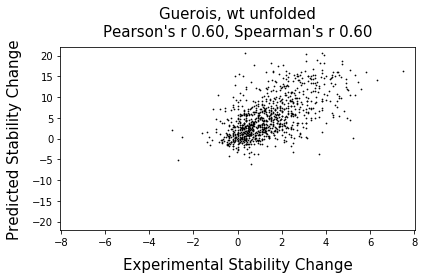

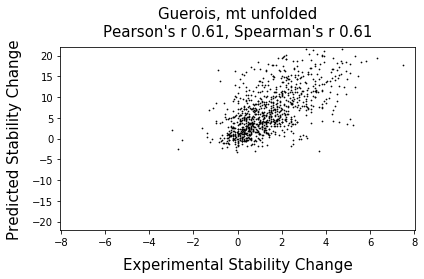

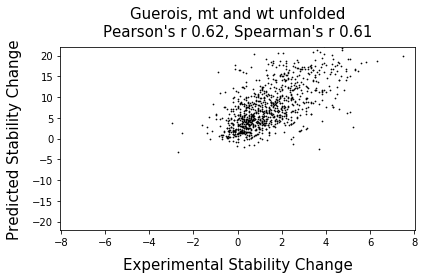

<IPython.core.display.Javascript object>

In [25]:
data_set = "guerois"
data_set_title = "Guerois"

helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=True
)
helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=False
)
helpers.add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, wt unfolded",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt unfolded",
)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt and wt unfolded",
)

#### DMS (Phaistos statistics)

In [26]:
# # DROP SOME ROWS FOR QUICKER TESTING
# ddg_data_dict["dms"] = ddg_data_dict["dms"].iloc[0:10]

<IPython.core.display.Javascript object>

In [27]:
data_set = "dms"
data_set_title = "DMS"

helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=True
)
helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=False
)
helpers.add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, wt unfolded",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt unfolded",
)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt and wt unfolded",
)

120 1D5R
121 1D5R
122 1D5R
123 1D5R
124 1D5R
125 1D5R
126 1D5R
127 1D5R
128 1D5R
129 1D5R
130 1D5R
131 1D5R
132 1D5R
133 1D5R
134 1D5R
135 1D5R
136 1D5R
137 1D5R
138 1D5R
139 1D5R
140 1D5R
141 1D5R
142 1D5R
143 1D5R
144 1D5R
145 1D5R
146 1D5R
147 1D5R
148 1D5R
149 1D5R
150 1D5R
151 1D5R
152 1D5R
153 1D5R
154 1D5R
155 1D5R
156 1D5R
157 1D5R
158 1D5R
159 1D5R
160 1D5R
161 1D5R
162 1D5R
163 1D5R
164 1D5R
165 1D5R
166 1D5R
167 1D5R
168 1D5R
169 1D5R
170 1D5R
171 1D5R
172 1D5R
173 1D5R
174 1D5R
175 1D5R
176 1D5R
177 1D5R
178 1D5R
179 1D5R
180 1D5R
181 1D5R
182 1D5R
183 1D5R
184 1D5R
185 1D5R
186 1D5R
187 1D5R
188 1D5R
189 1D5R
190 1D5R
191 1D5R
192 1D5R
193 1D5R
194 1D5R
195 1D5R
196 1D5R
197 1D5R
198 1D5R
199 1D5R
200 1D5R
201 1D5R
202 1D5R
203 1D5R
204 1D5R
205 1D5R
206 1D5R
207 1D5R
208 1D5R
209 1D5R
210 1D5R
211 1D5R
212 1D5R
213 1D5R
214 1D5R
215 1D5R
216 1D5R
217 1D5R
218 1D5R
219 1D5R
220 1D5R
221 1D5R
222 1D5R
223 1D5R
224 1D5R
225 1D5R
226 1D5R
227 1D5R
228 1D5R
229 1D5R
230 1D5R
2

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

##### Molecular dynamics

In [ ]:
# Infer NLLs for WT and MT  in columns wt_nll_md and mt_nll_md
helpers.infer_molecular_dynamics_nlls(
    ddg_data_dict, "protein_g", DEVICE, EPS, cavity_model_infer_net
)
helpers.infer_molecular_dynamics_nlls(
    ddg_data_dict, "guerois", DEVICE, EPS, cavity_model_infer_net
)
helpers.infer_molecular_dynamics_nlls(
    ddg_data_dict, "dms", DEVICE, EPS, cavity_model_infer_net
)

In [ ]:
# Calculate DDgs
helpers.add_ddg_preds_with_md_simulations(ddg_data_dict, "protein_g")
helpers.add_ddg_preds_with_md_simulations(ddg_data_dict, "guerois")
helpers.add_ddg_preds_with_md_simulations(ddg_data_dict, "dms")

In [ ]:
data_set = "protein_g"
data_set_title = "Protein G"
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD1",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_phaistos_mt_and_wt_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD5",
)

data_set = "guerois"
data_set_title = "Guerois"
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD1",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_phaistos_mt_and_wt_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD5",
)

data_set = "dms"
data_set_title = "DMS"
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD1",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_phaistos_mt_and_wt_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD5",
)

In [ ]:
# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_idp_statistics_no_ds"],
#     color="black",
#     title="protein G, MD2",
# )

# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_phaistos_wt_statistics_no_ds"],
#     color="black",
#     title="protein G, MD3",
# )

# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_phaistos_mt_statistics_no_ds"],
#     color="black",
#     title="protein G, MD4",
# )


# Downstream model

### Performance without augmentation

Define training dataloader and eval dataloaders

In [ ]:
ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
    ddg_data_dict, BATCH_SIZE_DDG, SHUFFLE_DDG
)
ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(ddg_data_dict)

Train and report on the data that is not used during training

In [ ]:
# pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

In [ ]:
# for key in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(key, pearsons_r_results_dict[key])

### Performance with augmentation

Before training we "augment" our dataset simply by adding the reverse mutation with -ddG value

In [ ]:
# ddg_data_dict_augmented = helpers.augment_with_reverse_mutation(ddg_data_dict)

Define training dataloader (augmented data) and eval dataloaders (original data)

In [ ]:
# ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
#     ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG
# )
# ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(ddg_data_dict)

Train and report on the data that is not used during training

In [ ]:
# pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

In [ ]:
# for key in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(key, pearsons_r_results_dict[key])